# Deep Generative Models for COVID 19 Drug Discovery
### VISUM 2022 - Hands-on Session
### Prepared by Helena Montenegro, Eduardo Castro, Matteo Manica and Michal Rosen-Zvi

This hands-on session will use [GT4SD](https://github.com/GT4SD/gt4sd-core) to generate potential new drugs for treating COVID-19. Our goal is to find molecules that i) **bind** to the desired target protein; ii) are **non-toxic**; iii) can be **easily synthesized**.

In [1]:
import os
disable_gpu = True
if disable_gpu:
    os.environ["CUDA_VISIBLE_DEVICES"] = ""
import tensorflow as tf

2022-06-22 18:39:12.879162: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libnvinfer.so.6'; dlerror: libnvinfer.so.6: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64
2022-06-22 18:39:12.879228: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libnvinfer_plugin.so.6'; dlerror: libnvinfer_plugin.so.6: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64
2022-06-22 18:39:12.879235: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:30] Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


## Choosing a target protein

Our first step is to choose a target protein. To find COVID-related proteins, both from human and coronavirus organisms, we can use the following site [covid-19.uniprot.org](https://covid-19.uniprot.org/). The well-known [spike glycoprotein](https://covid-19.uniprot.org/uniprotkb/P0DTC2) is the one that initiates the infection of host cells and so we will be using that for this tutorial. Feel free to explore other target proteins.

<ins>**Note:** String representation of proteins</ins>
> Protein molecules are long sequences of aminoacids. There are a total of 20 of these basic units used by the human body and so we can code each with a letter, and the whole protein as a string (sequence of letters). For more information on this code you can check [here](http://web.mit.edu/meme_v4.11.4/share/doc/alphabets.html#protein).

**Exercise: Change the string below to the desired target protein.**

In [2]:
# This is an example string for the ACE2_HUMAN Angiotensin-converting enzyme 2
# Change this so that this string codes for the desired target protein
string = """
MSSSSWLLLSLVAVTAAQSTIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQ
NMNNAGDKWSAFLKEQSTLAQMYPLQEIQNLTVKLQLQALQQNGSSVLSEDKSKRLNTIL
NTMSTIYSTGKVCNPDNPQECLLLEPGLNEIMANSLDYNERLWAWESWRSEVGKQLRPLY
EEYVVLKNEMARANHYEDYGDYWRGDYEVNGVDGYDYSRGQLIEDVEHTFEEIKPLYEHL
HAYVRAKLMNAYPSYISPIGCLPAHLLGDMWGRFWTNLYSLTVPFGQKPNIDVTDAMVDQ
AWDAQRIFKEAEKFFVSVGLPNMTQGFWENSMLTDPGNVQKAVCHPTAWDLGKGDFRILM
CTKVTMDDFLTAHHEMGHIQYDMAYAAQPFLLRNGANEGFHEAVGEIMSLSAATPKHLKS
IGLLSPDFQEDNETEINFLLKQALTIVGTLPFTYMLEKWRWMVFKGEIPKDQWMKKWWEM
KREIVGVVEPVPHDETYCDPASLFHVSNDYSFIRYYTRTLYQFQFQEALCQAAKHEGPLH
KCDISNSTEAGQKLFNMLRLGKSEPWTLALENVVGAKNMNVRPLLNYFEPLFTWLKDQNK
NSFVGWSTDWSPYADQSIKVRISLKSALGDKAYEWNDNEMYLFRSSVAYAMRQYFLKVKN
QMILFGEEDVRVANLKPRISFNFFVTAPKNVSDIIPRTEVEKAIRMSRSRINDAFRLNDN
SLEFLGIQPTLGPPNQPPVSIWLIVFGVVMGVIVVGIVILIFTGIRDRKKKNKARSGENP
YASIDISKGENNPGFQNTDDVQTSF
"""
target_protein = "".join(filter(str.isalpha, (list(string))))

## Defining metrics of interest

The following metrics will be used to quantify properties of interest in the generated molecules:

- **drug-likeness (QED)**
    
> This is a quantitative measure of how close a molecule is to approved drugs, and is estimated based on different molecular properties. A similar structure to approved drugs increases the likelihood of the molecule having desirable properties.
    
    
- **aquous solubility**
- **synthetic accessibility score (SAS)**

> Measures how synthesiable a molecule is.


- **molecular weight**

In [3]:
from rdkit import Chem
from paccmann_generator.drug_evaluators.esol import ESOL
from paccmann_generator.drug_evaluators.sas import SAS
from paccmann_generator.drug_evaluators.scsore import SCScore

#descriptors
def get_drug_likeness(mol):                   # drug likeness
    try:
        return Chem.QED.qed(mol)               
    except:
        return 0.0

get_solubility = ESOL()                        # solubility
get_synthesizability = SCScore()               # synthesizability
get_molecularWeight = Chem.Descriptors.MolWt   # molecular weight

/home/emcastro/miniconda3/envs/gt4sd/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## GT4SD (Generative Toolkit for Scientific Discovery)

> The GT4SD (Generative Toolkit for Scientific Discovery) is an open-source platform to accelerate hypothesis generation in the scientific discovery process. It provides a library for making state-of-the-art generative AI models easier to use.

In this tutorial we will cover two generative methods, but feel free to further explore the platform on your own ([Getting started](https://github.com/GT4SD/gt4sd-core#getting-started))

## Generation with PaccMannRL

**PaccMannRL** was devised for generating molecules targeting a specific protein or biomolecular profile. In this tutorial, given a protein, we want to obtain a compound that maximizes protein-drug binding affinity.

![PaccMannRL graphical abstract](pacrl.jpg "from [2]")


The PaccMannRL model is composed of three basic modules:

- **Protein VAE**: creates a latent representation of the target protein;
- **Compound VAE**: generates a compound as a sequence;
- **Multimodal critic model**: given the protein and a compound, predicts the protein-drug binding affinity.

<ins>**Note:** Variational Autoencoder</ins>
> If you want to learn more about VAEs, you can find it here. You can also read more on sequential VAEs and Denoising VAEs.


Each of these modules are pretrained separately. The Protein VAE is trained as a denoising VAE, the Compound VAE as a sequential VAE and finally, the Multimodel critic as a regression model. Then, they are put together in the same network. Using the encoder of the Protein VAE creates a latent representation of the target protein. Then, the protein’s latent representation is provided as input to the decoder of the Compound VAE, which originates a new compound. A reinforcement learning strategy is used to optimize the Protein encoder and Compount decoder, using the critic's output as reward.


**References:**

[1] - Born, J., Manica, M., Cadow, J., Markert, G., Mill, N. A., Filipavicius, M., Janakarajan, N., Cardinale, A., Laino, T., &amp; Rodríguez Martínez, M. (2021). Data-driven molecular design for discovery and synthesis of novel ligands: A case study on SARS-COV-2. Machine Learning: Science and Technology, 2(2), 025024. https://doi.org/10.1088/2632-2153/abe808

[2] - Born, J., Manica, M., Oskooei, A., Cadow, J., Markert, G., &amp; Rodríguez Martínez, M. (2021). PACCMANNRL: De novo generation of hit-like anticancer molecules from transcriptomic data via reinforcement learning. IScience, 24(4), 102269. https://doi.org/10.1016/j.isci.2021.102269 


### Configuring the model

Our first step is to initialize the algorithm with the target chosen in the previous step.

In [4]:
from gt4sd.algorithms.conditional_generation.paccmann_rl.core import PaccMannRL, PaccMannRLProteinBasedGenerator


# possible arguments generated_length=100
configuration = PaccMannRLProteinBasedGenerator()
algorithm = PaccMannRL(configuration=configuration, target=target_protein)

Using TensorFlow backend.


No CUDA runtime is found, using CUDA_HOME='/usr/local/cuda'
18:39:19   using as local cache path: /home/emcastro/.gt4sd
18:39:19   Better speed can be achieved with apex installed from https://www.github.com/nvidia/apex .
18:39:19   runnning PaccMannRL with configuration=PaccMannRLProteinBasedGenerator(algorithm_version='v0', batch_size=32, temperature=1.4, generated_length=100)
18:39:19   ensure artifacts for the application are present.
18:39:19   starting syncing
18:39:20   syncing complete
18:39:20   loading configuration file https://s3.amazonaws.com/songlabdata/proteindata/pytorch-models/bert-base-config.json from cache at /home/emcastro/.cache/torch/protein_models/fbb05edff0ffa844a729a04850272a1f8973bc002526f6615ad113a5f5aacd36.05edb4ed225e1907a3878f9d68b275d79e025b667555aa94a086e27cb5c591e0
18:39:20   Model config {
  "attention_probs_dropout_prob": 0.1,
  "base_model": "transformer",
  "finetuning_task": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_siz

### Visualizing its components (summary)

To generate molecules we only need the protein encoder and the compound generator.
In the code below:

- **Sequence Embedder**: maps the protein string into an embedding space;

- **Protein Encoder**: encodes the result of the sequence embedder into the latent representation of the Protein VAE;

- **Generator**: Compound VAE.

In [5]:
model = configuration.get_conditional_generator(configuration.ensure_artifacts())

print("\n\nLet's look at the models that will be used in the generation process:")

print("Sequence Embedder")
for n, c in model.primary_sequence_embedder.named_modules():
    if n.count(".")==1:
        print("\t", n)

print("Protein Encoder")
for n, c in model.protein_embedding_encoder.named_modules():
    if n.count(".")==0 and n!="":
        print("\t", n)

print("Generator")
for n, c in model.selfies_conditional_generator.named_modules():
    if n.count(".")==0 and n!="":
        print("\t", n)

18:39:22   starting syncing
18:39:22   syncing complete
18:39:23   loading configuration file https://s3.amazonaws.com/songlabdata/proteindata/pytorch-models/bert-base-config.json from cache at /home/emcastro/.cache/torch/protein_models/fbb05edff0ffa844a729a04850272a1f8973bc002526f6615ad113a5f5aacd36.05edb4ed225e1907a3878f9d68b275d79e025b667555aa94a086e27cb5c591e0
18:39:23   Model config {
  "attention_probs_dropout_prob": 0.1,
  "base_model": "transformer",
  "finetuning_task": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "input_size": 768,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 8192,
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "num_labels": -1,
  "output_attentions": false,
  "output_hidden_states": false,
  "output_size": 768,
  "pruned_heads": {},
  "torchscript": false,
  "type_vocab_size": 1,
  "vocab_size": 30
}

18:39:23   loading weights file https://

#### Example: Generating one molecule using the Compound VAE

The code below shows how we can use the decoder of a sequential VAE to generate a compound (i.e., sequence of tokens). Notice that this is an illustrative example, since we do not condition the Compound Decoder on the protein target, as we do in PaccMannRL.

We start by defining some parameters. 

The **generate_len** is the maximum size of the generated sequence. **search** defines how we decide the search strategy used after each iteration of the decoder.

In [6]:
import torch
from pytoda.smiles.smiles_language import SMILESLanguage
from paccmann_chemistry.utils.search import SamplingSearch

# parameters for the generation
batch_size = 1
search = SamplingSearch()
prime_input = torch.tensor([SMILESLanguage().start_index])
end_token = torch.tensor([SMILESLanguage().stop_index])
generate_len = 100

# grab the decoder model
decoder = model.selfies_conditional_generator.decoder
decoder._update_batch_size(batch_size)

We start by sampling a random vector in the latent representation of the compound VAE. Our initial molecule is an empty sequence, containing only the input token.

In [7]:
# generate latent vectors
latent_z = torch.randn(1, batch_size, decoder.latent_dim)
latent_z = latent_z.repeat(decoder.n_layers, 1, 1)

# empty sequence
generated_seq = prime_input.repeat(batch_size, 1)
prime_input = generated_seq.transpose(1, 0).unsqueeze(1)
input_token = prime_input[-1]

# first pass t=0
hidden = decoder.latent_to_hidden(latent_z)
stack = decoder.init_stack

In each iteration we generate an additional token. For this we first compute the probabilities of each token being the next in the sequence and then sample one based on our search strategy. We append it to the end of our sequence and set it as the input token for the next iteration. If the **end_token** is returned we exit the loop.

> In the example below, molecules_numerical is a list with all the intermediate molecules generated during the process. It serves only for visualization purposes.

In [8]:
smiles_language = model.smiles_language

molecules_numerical = []

for idx in range(generate_len):
    output, hidden, stack = decoder(input_token, hidden, stack)
    logits = decoder.output_layer(output).squeeze(dim=0)
    top_idx = search.step(logits)

    input_token = top_idx.view(1, -1).to(decoder.device)
    generated_seq = torch.cat((generated_seq, top_idx), dim=1)
    
    #print(f"Step {idx} - Tokens: {','.join([str(x) for x in generated_seq[0].cpu().numpy()])}")
    print(f"Step {idx} - Tokens: {smiles_language.token_indexes_to_smiles(generated_seq[0].tolist())}\n")

    # if we don't generate in batches, we can do early stopping.
    if batch_size == 1 and top_idx == end_token:
        break
    
    molecules_numerical.append(torch.cat((generated_seq, end_token.view(1,1)), dim=1)[0])

Step 0 - Tokens: [C]

Step 1 - Tokens: [C][C]

Step 2 - Tokens: [C][C][C]

Step 3 - Tokens: [C][C][C][C]

Step 4 - Tokens: [C][C][C][C][Branch1_3]

Step 5 - Tokens: [C][C][C][C][Branch1_3][#C]

Step 6 - Tokens: [C][C][C][C][Branch1_3][#C][N]

Step 7 - Tokens: [C][C][C][C][Branch1_3][#C][N][C]

Step 8 - Tokens: [C][C][C][C][Branch1_3][#C][N][C][Branch1_3]

Step 9 - Tokens: [C][C][C][C][Branch1_3][#C][N][C][Branch1_3][epsilon]

Step 10 - Tokens: [C][C][C][C][Branch1_3][#C][N][C][Branch1_3][epsilon][=O]

Step 11 - Tokens: [C][C][C][C][Branch1_3][#C][N][C][Branch1_3][epsilon][=O][C]

Step 12 - Tokens: [C][C][C][C][Branch1_3][#C][N][C][Branch1_3][epsilon][=O][C][Branch1_3]

Step 13 - Tokens: [C][C][C][C][Branch1_3][#C][N][C][Branch1_3][epsilon][=O][C][Branch1_3][=O]

Step 14 - Tokens: [C][C][C][C][Branch1_3][#C][N][C][Branch1_3][epsilon][=O][C][Branch1_3][=O][C]

Step 15 - Tokens: [C][C][C][C][Branch1_3][#C][N][C][Branch1_3][epsilon][=O][C][Branch1_3][=O][C][c]

Step 16 - Tokens: [C][C][C][

We now decode the tokens in the generated sequences into the SMILES language (and clean-up) so that we can visualize the molecules. Some molecules generated intermediatly are not valid and so they are filtered.

In [9]:
import mols2grid

def remove_none_and_duplicate(seq):
    pool = []
    result = []
    for mol in seq:
        if mol is None:
            continue
        if mol in pool:
            continue
        result.append(mol)
    return result

smiles_num = [smiles_language.token_indexes_to_smiles(molecule_numerical.tolist())
              for molecule_numerical in iter(molecules_numerical)]

smiles = [smiles_language.selfies_to_smiles(sm) for sm in smiles_num]

molecules = []
for a_smiles in smiles:    
    try:
        molecules.append(Chem.MolFromSmiles(a_smiles, sanitize=True))
        # This is used to catch errors in Chem.MolFromSmiles.
        # To debug remove from the try/except clause.
        
    except Exception:
        molecules.append(None)

molecules = remove_none_and_duplicate(molecules)
mols2grid.display(molecules, n_rows=10, fixedBondLength=200)

### Sampling and Plotting Molecules with GT4SD

Let's go ahead and sample some molecules using the PaccMannRL algorithm.
This time we will use the GT4SD interface, which greatly simplifies sampling for us.
We start by sampling 15 molecules. We then convert them into a **Mol** object (**RDKit** package).
Finally, we display them using the **mols2grid** package.

In [10]:
n_sampled_molecules = 15
molecules = list(algorithm.sample(n_sampled_molecules))
molecules = [Chem.MolFromSmiles(molecule) for molecule in molecules]
mols2grid.display(molecules, fixedBondLength=200)

18:39:25   embedding condition and getting reparametrized latent samples
18:39:26   starting generation of molecules
18:39:27   embedding condition and getting reparametrized latent samples
18:39:27   starting generation of molecules
18:39:28   embedding condition and getting reparametrized latent samples
18:39:29   starting generation of molecules


### Evaluating the generated molecules

If we want to compare different algorithms, we can do so using different metrics. This next example shows how to estimate the properties of generated molecules using the PaccMannRL algorithm. We start by generating 100 new molecules. For each we compute the metrics defined in the beggining of the tutorial.

In [11]:
n = 100
molecules = list(algorithm.sample(n))

drug_likeness = []
solubility = []
synthesizability = []
molecular_weight = []
affinity = []

for molecule in molecules:
    mol = Chem.MolFromSmiles(molecule)
    drug_likeness.append(get_drug_likeness(mol))
    solubility.append(get_solubility(mol))
    synthesizability.append(get_synthesizability(mol))
    molecular_weight.append(get_molecularWeight(mol))

18:39:29   embedding condition and getting reparametrized latent samples
18:39:30   starting generation of molecules
18:39:31   embedding condition and getting reparametrized latent samples
18:39:32   starting generation of molecules
18:39:32   embedding condition and getting reparametrized latent samples
18:39:33   starting generation of molecules
18:39:34   embedding condition and getting reparametrized latent samples
18:39:34   starting generation of molecules
18:39:35   embedding condition and getting reparametrized latent samples
18:39:36   starting generation of molecules
18:39:36   embedding condition and getting reparametrized latent samples
18:39:37   starting generation of molecules
18:39:38   embedding condition and getting reparametrized latent samples
18:39:39   starting generation of molecules
18:39:39   embedding condition and getting reparametrized latent samples
18:39:40   starting generation of molecules
18:39:41   embedding condition and getting reparametrized latent

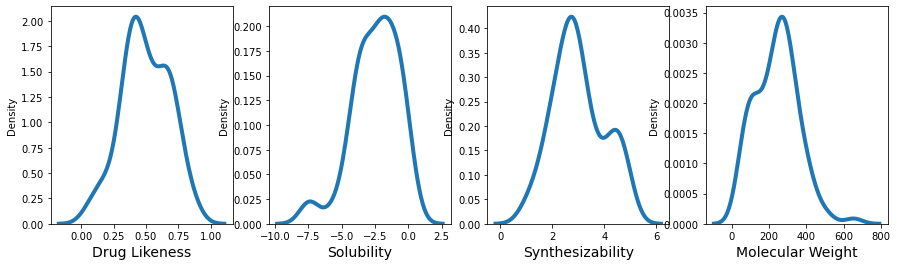

Out of the 100 generated molecules, 7 have a drug likeness equal or greater than 0.75.


In [12]:
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
plt.rcParams["figure.figsize"] = (10,7)

def plot_density(values, x_axis="", subplot=1):
    plt.subplot(1, 4, subplot)
    g = sns.distplot(values, hist=False, kde_kws={"linewidth": 4})
    plt.xlabel(x_axis, size=14)

plt.gcf().set_size_inches(15,4)
plot_density(drug_likeness, "Drug Likeness", subplot=1)
plot_density(solubility, "Solubility", subplot=2)
plot_density(synthesizability, "Synthesizability", subplot=3)
plot_density(molecular_weight, "Molecular Weight", subplot=4)
plt.show()

threshold = 0.75
number_of_potential_molecules = len([qed for qed in drug_likeness if qed>=threshold])
print(f"Out of the {n} generated molecules, {number_of_potential_molecules} have a drug likeness equal or greater than {threshold}.")

One of the most important metrics is drug likeness. We define the threshold of 0.75 and are "satisfied" with molecules that surpass that value. We will use the number of molecules that surpass this level to compare different algorithms.

### Visualizing the embedding space

We can visualize the embedding space of the Variational Autoencoder. It can give us an idea of how this space is organized, and hint at how the VAE may be encoding different molecules.

For this, we:
- randomly generate points in the latent space;
- keep the points that correspond to valid molecules;
- plot those points using a 2D approximation;

We visualize how different chemical properties are distributed in the latent space.

Notice that we are compacting a high dimensional subspace into a 2D plot, and thus, necessarily loosing information.

In [13]:
from tqdm import tqdm

# generate randomly points in the latent space
number_of_latent_points = 2048
latent_points = torch.randn(number_of_latent_points,
                            model.encoder_latent_size,
                            device=model.device)

# keep points which correspond to valid molecules
molecules = []
for latent_point in tqdm(torch.unsqueeze(latent_points, 1)):
    smiles_list = model.get_smiles_from_latent(latent_point)
    generated_molecules = [Chem.MolFromSmiles(smiles) for smiles in smiles_list][:1]  # keeping only a molecule per point
    molecules.extend(generated_molecules)
valid_indexes = [index for index, molecule in enumerate(molecules) if molecule is not None]
molecules = [molecules[index] for index in valid_indexes]
latent_points = latent_points[valid_indexes]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2048/2048 [02:47<00:00, 12.22it/s]


**Exercise: comment/uncomment the code below to display different properties in the latent space**

**Exercise: comment/uncomment the code below to use different algorithms for dimentionality reduction (TSNE/PCA)**

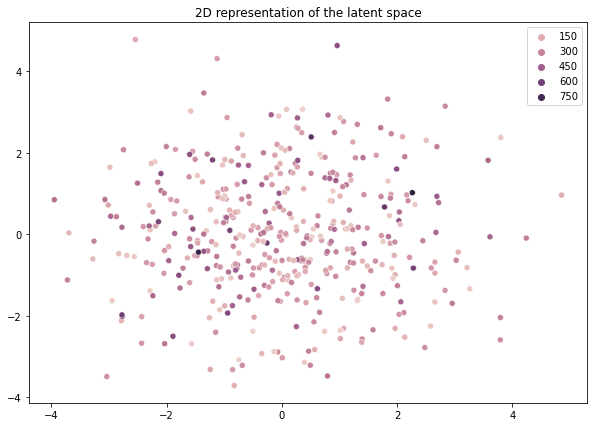

In [14]:
# Visualization
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import seaborn as sns
%matplotlib inline
plt.rcParams["figure.figsize"] = (10,7)

def render_latent_points(latent_points, values):
    decomposed_points = PCA(n_components=2).fit_transform(latent_points)
    #decomposed_points = TSNE(n_components=2).fit_transform(latent_points)
    sns.scatterplot(x=decomposed_points[:, 0], y=decomposed_points[:, 1], hue=values)

values=[]
for molecule in molecules:
    try:
        #values.append(get_drug_likeness(molecule))
        #values.append(get_solubility(molecule))
        #values.append(get_synthesizability(molecule))
        values.append(get_molecularWeight(molecule))
    except:
        values.append(0.0)
_ = render_latent_points(latent_points.cpu(), values=values)
_ = plt.title("2D representation of the latent space")

## Generation with PaccMannGP


The goal of the PaccMannGP method is to generate new molecules that optimize predefined
parameters, such as drug likeness.


The model used in PaccMannGP is a standard Variational Autoencoder for molecular design,
trained with the standard reconstruction and regularization losses. The encoder of the VAE
maps a molecule into a latent space with a Gaussian distribution, where it is possible to sample
new data points. The decoder performs the reverse operation by translating data points from
the latent space into the original data space.

The method performs Bayesian Optimization with Gaussian Processes to explore the latent
space of the VAE, aiming to find a compound that maximizes drug likeness. Then, the method
uses the decoder of the VAE to obtain the compound that was found to maximize drug likeness
in the latent space.


**References:**

[1] - Born J., Huynh T., Stroobants A., Cornell W. D. , and Manica M. (2022). Active Site Sequence Representations of Human Kinases Outperform Full Sequence Representations for Affinity Prediction and Inhibitor Generation: 3D Effects in a 1D Model. Journal of Chemical Information and Modeling 2022 62 (2), 240-257
https://doi.org/10.1021/acs.jcim.1c00889

### Configuring the model

In [15]:
from gt4sd.algorithms.controlled_sampling.paccmann_gp.core import PaccMannGP, PaccMannGPGenerator

# maximizing drug likeness and synthesizability
target = {"qed": {"weight": 1.0},
          "sa": {"weight": 1.0}}

configuration = PaccMannGPGenerator()
algorithm = PaccMannGP(configuration=configuration, target=target)

18:42:42   runnning PaccMannGP with configuration=PaccMannGPGenerator(algorithm_version='v0', batch_size=32, temperature=1.4, generated_length=100, limit=5.0, acquisition_function='EI', number_of_steps=32, number_of_initial_points=16, initial_point_generator='random', seed=42, number_of_optimization_rounds=1, sampling_variance=0.1, samples_for_evaluation=4, maximum_number_of_sampling_steps=32)
18:42:42   ensure artifacts for the application are present.
18:42:42   starting syncing
18:42:42   syncing complete


### Sampling and Plotting Molecules with GT4SD

Let's go ahead and sample some molecules using the PaccMannRL algorithm.
This time we will use the GT4SD interface, which greatly simplifies sampling for us.
We start by sampling 15 molecules. We then convert them into a **Mol** object (**RDKit** package).
Finally, we display them using the **mols2grid** package.

In [16]:
n_sampled_molecules = 15
molecules = list(algorithm.sample(n_sampled_molecules))
molecues = [Chem.MolFromSmiles(molecule) for molecule in molecules]
mols2grid.display(molecues, fixedBondLength=200)

18:42:43   configuring optimization for target: {'qed': {'weight': 1.0}, 'sa': {'weight': 1.0}}
18:42:43   running optimization with the following parameters: {'dimensions': [(-5.0, 5.0), (-5.0, 5.0), (-5.0, 5.0), (-5.0, 5.0), (-5.0, 5.0), (-5.0, 5.0), (-5.0, 5.0), (-5.0, 5.0), (-5.0, 5.0), (-5.0, 5.0), (-5.0, 5.0), (-5.0, 5.0), (-5.0, 5.0), (-5.0, 5.0), (-5.0, 5.0), (-5.0, 5.0), (-5.0, 5.0), (-5.0, 5.0), (-5.0, 5.0), (-5.0, 5.0), (-5.0, 5.0), (-5.0, 5.0), (-5.0, 5.0), (-5.0, 5.0), (-5.0, 5.0), (-5.0, 5.0), (-5.0, 5.0), (-5.0, 5.0), (-5.0, 5.0), (-5.0, 5.0), (-5.0, 5.0), (-5.0, 5.0), (-5.0, 5.0), (-5.0, 5.0), (-5.0, 5.0), (-5.0, 5.0), (-5.0, 5.0), (-5.0, 5.0), (-5.0, 5.0), (-5.0, 5.0), (-5.0, 5.0), (-5.0, 5.0), (-5.0, 5.0), (-5.0, 5.0), (-5.0, 5.0), (-5.0, 5.0), (-5.0, 5.0), (-5.0, 5.0), (-5.0, 5.0), (-5.0, 5.0), (-5.0, 5.0), (-5.0, 5.0), (-5.0, 5.0), (-5.0, 5.0), (-5.0, 5.0), (-5.0, 5.0), (-5.0, 5.0), (-5.0, 5.0), (-5.0, 5.0), (-5.0, 5.0), (-5.0, 5.0), (-5.0, 5.0), (-5.0, 5.0), (-5.0,

2022-06-22 18:43:03.750 | WARNING  | paccmann_gp.qed_minimization:evaluate:48 - QED calculation failed.


18:43:32   starting sampling for 1
18:43:51   completing round 1
18:43:51   generated 215 molecules in the current run


### Evaluating the generated molecules

If we want to compare different algorithms, we can do so using different metrics. This next example shows how to estimate the properties of generated molecules using the PaccMannRL algorithm. We start by generating 100 new molecules. For each we compute the metrics defined in the beggining of the tutorial.

In [ ]:
n = 100
molecules = list(algorithm.sample(n))

drug_likeness = []
solubility = []
synthesizability = []
molecular_weight = []
affinity = []

for molecule in molecules:
    mol = Chem.MolFromSmiles(molecule)
    drug_likeness.append(get_drug_likeness(mol))
    solubility.append(get_solubility(mol))
    synthesizability.append(get_synthesizability(mol))
    molecular_weight.append(get_molecularWeight(mol))

18:43:52   configuring optimization for target: {'qed': {}, 'sa': {}}
18:43:52   running optimization with the following parameters: {'dimensions': [(-5.0, 5.0), (-5.0, 5.0), (-5.0, 5.0), (-5.0, 5.0), (-5.0, 5.0), (-5.0, 5.0), (-5.0, 5.0), (-5.0, 5.0), (-5.0, 5.0), (-5.0, 5.0), (-5.0, 5.0), (-5.0, 5.0), (-5.0, 5.0), (-5.0, 5.0), (-5.0, 5.0), (-5.0, 5.0), (-5.0, 5.0), (-5.0, 5.0), (-5.0, 5.0), (-5.0, 5.0), (-5.0, 5.0), (-5.0, 5.0), (-5.0, 5.0), (-5.0, 5.0), (-5.0, 5.0), (-5.0, 5.0), (-5.0, 5.0), (-5.0, 5.0), (-5.0, 5.0), (-5.0, 5.0), (-5.0, 5.0), (-5.0, 5.0), (-5.0, 5.0), (-5.0, 5.0), (-5.0, 5.0), (-5.0, 5.0), (-5.0, 5.0), (-5.0, 5.0), (-5.0, 5.0), (-5.0, 5.0), (-5.0, 5.0), (-5.0, 5.0), (-5.0, 5.0), (-5.0, 5.0), (-5.0, 5.0), (-5.0, 5.0), (-5.0, 5.0), (-5.0, 5.0), (-5.0, 5.0), (-5.0, 5.0), (-5.0, 5.0), (-5.0, 5.0), (-5.0, 5.0), (-5.0, 5.0), (-5.0, 5.0), (-5.0, 5.0), (-5.0, 5.0), (-5.0, 5.0), (-5.0, 5.0), (-5.0, 5.0), (-5.0, 5.0), (-5.0, 5.0), (-5.0, 5.0), (-5.0, 5.0), (-5.0, 5.0), (-5.0,

In [ ]:
def plot_density(values, x_axis="", subplot=1):
    plt.subplot(1, 4, subplot)
    g = sns.distplot(values, hist=False, kde_kws={"linewidth": 4})
    plt.xlabel(x_axis, size=14)

plt.gcf().set_size_inches(15,4)
plot_density(drug_likeness, "Drug Likeness", subplot=1)
plot_density(solubility, "Solubility", subplot=2)
plot_density(synthesizability, "Synthesizability", subplot=3)
plot_density(molecular_weight, "Molecular Weight", subplot=4)
plt.show()

threshold = 0.75
number_of_potential_molecules = len([qed for qed in drug_likeness if qed>=threshold])
print(f"Out of the {n} generated molecules, {number_of_potential_molecules} have a drug likeness equal or greater than {threshold}.")